**классификатор изображений (HOG)**

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
# !pip3 install scikit-image

In [2]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt

Navneet Dalal and Bill Triggs  
Histograms of Oriented Gradients for Human Detection.     
http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf


Satya Mallick  
Histogram of Oriented Gradients explained using OpenCV.      
https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8

## подготовка данных

In [3]:
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import cifar10

(image_train, target_train),(image_test, target_test) = cifar10.load_data()

target_train = target_train.flatten()
target_test = target_test.flatten()

image_train.shape, image_test.shape

2022-11-04 12:59:41.714713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 12:59:41.829693: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 12:59:42.312942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64::/opt/cuda/lib64
2022-11-04 12:59:42.313043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.

((50000, 32, 32, 3), (10000, 32, 32, 3))

Гистограмма направленных градиентов (Histogram of Oriented Gradients, HOG)

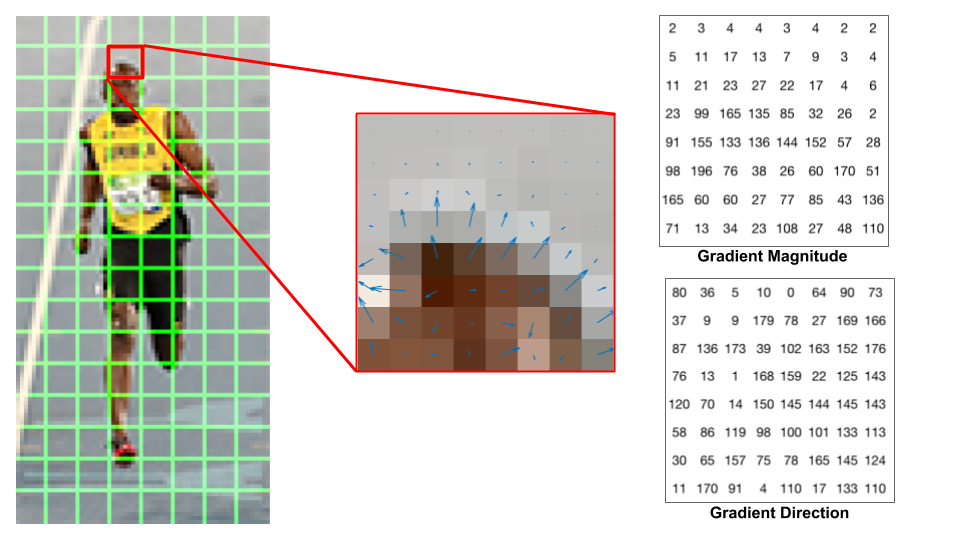

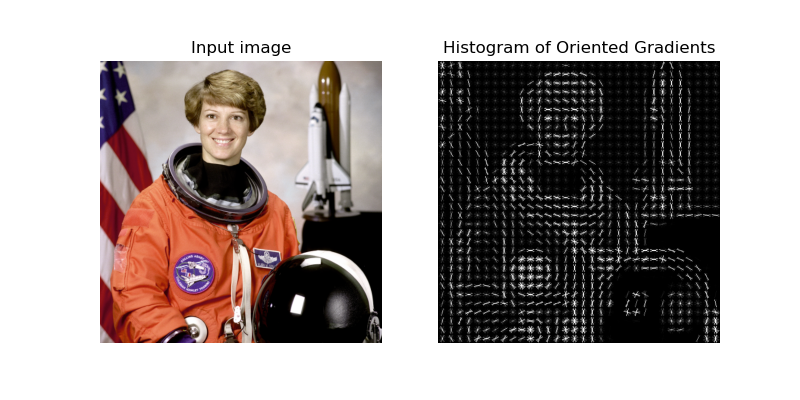

In [4]:
from skimage.feature import hog

In [5]:
32/16

2.0

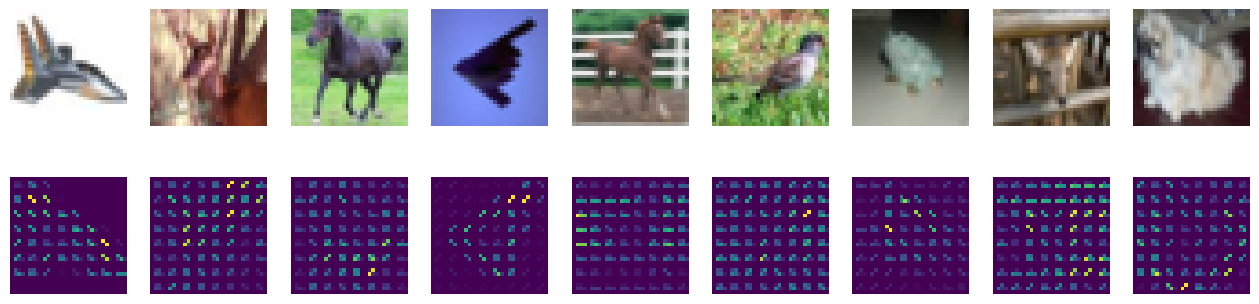

In [6]:
n_show = 9
ppc,cpb = (4,4),(2,2) # pixels per cell, cells per block

plt.figure(figsize=(16,4))
for n,i in enumerate(rng.permutation(len(image_train))[:n_show], start=1):
    img = image_train[i]
    
    plt.subplot(2,n_show,n)
    plt.axis(False)
    plt.imshow(img,cmap='gray_r')

    _,hog_img = hog(img,pixels_per_cell=ppc,cells_per_block=cpb,visualize=True,channel_axis=-1)
    plt.subplot( 2, n_show, n+n_show)
    plt.axis(False)
    plt.imshow(hog_img) #,cmap='gray_r')

In [7]:
%%time

from tqdm.notebook import tqdm

X_train = np.array([hog(x,pixels_per_cell=ppc,cells_per_block=cpb,channel_axis=-1) for x in tqdm(image_train)])
X_test  = np.array([hog(x,pixels_per_cell=ppc,cells_per_block=cpb,channel_axis=-1) for x in tqdm(image_test) ])

X_train.shape, X_test.shape

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 1min 10s, sys: 507 ms, total: 1min 10s
Wall time: 1min 11s


((50000, 1764), (10000, 1764))

In [8]:
# target_train

## обучение модели

In [9]:
from sklearn.model_selection import train_test_split

X_train_, _, y_train_, _ = train_test_split( X_train, target_train, train_size=.10)

X_train_.shape, y_train_.shape

((5000, 1764), (5000,))

In [10]:
# %%time

# from sklearn import svm

# model = svm.SVC().fit(X_train_,y_train_)

In [11]:
%%time

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier( n_jobs=-1, ).fit(X_train, target_train)

CPU times: user 2min 30s, sys: 426 ms, total: 2min 30s
Wall time: 40.1 s


In [12]:
# svm.SVC?

## оценка результатов

In [13]:
%%time 

o_test = model.predict(X_test)

CPU times: user 698 ms, sys: 12.6 ms, total: 711 ms
Wall time: 239 ms


In [14]:
class_names = [ 
'airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

In [15]:
from sklearn.metrics import classification_report

print(classification_report(target_test, o_test, target_names=class_names) ) 

              precision    recall  f1-score   support

    airplane       0.54      0.53      0.53      1000
  automobile       0.57      0.67      0.62      1000
        bird       0.39      0.32      0.35      1000
         cat       0.31      0.25      0.28      1000
        deer       0.38      0.40      0.39      1000
         dog       0.36      0.40      0.38      1000
        frog       0.49      0.59      0.53      1000
       horse       0.53      0.45      0.48      1000
        ship       0.51      0.54      0.53      1000
       truck       0.53      0.51      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000



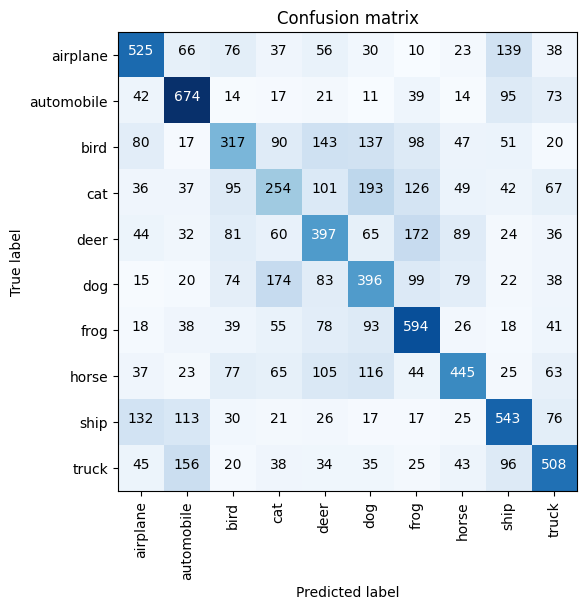

In [16]:
# матрица ошибок
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(target_test,o_test)

classes=class_names
thresh = cm.max()/2.
tick_marks = np.arange(len(classes))

fig = plt.figure(figsize=(6,6))
plt.title('Confusion matrix')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    c = 'white' if cm[i,j] > thresh else 'black'
    plt.text(j,i, f'{cm[i,j]}',horizontalalignment="center",color=c)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

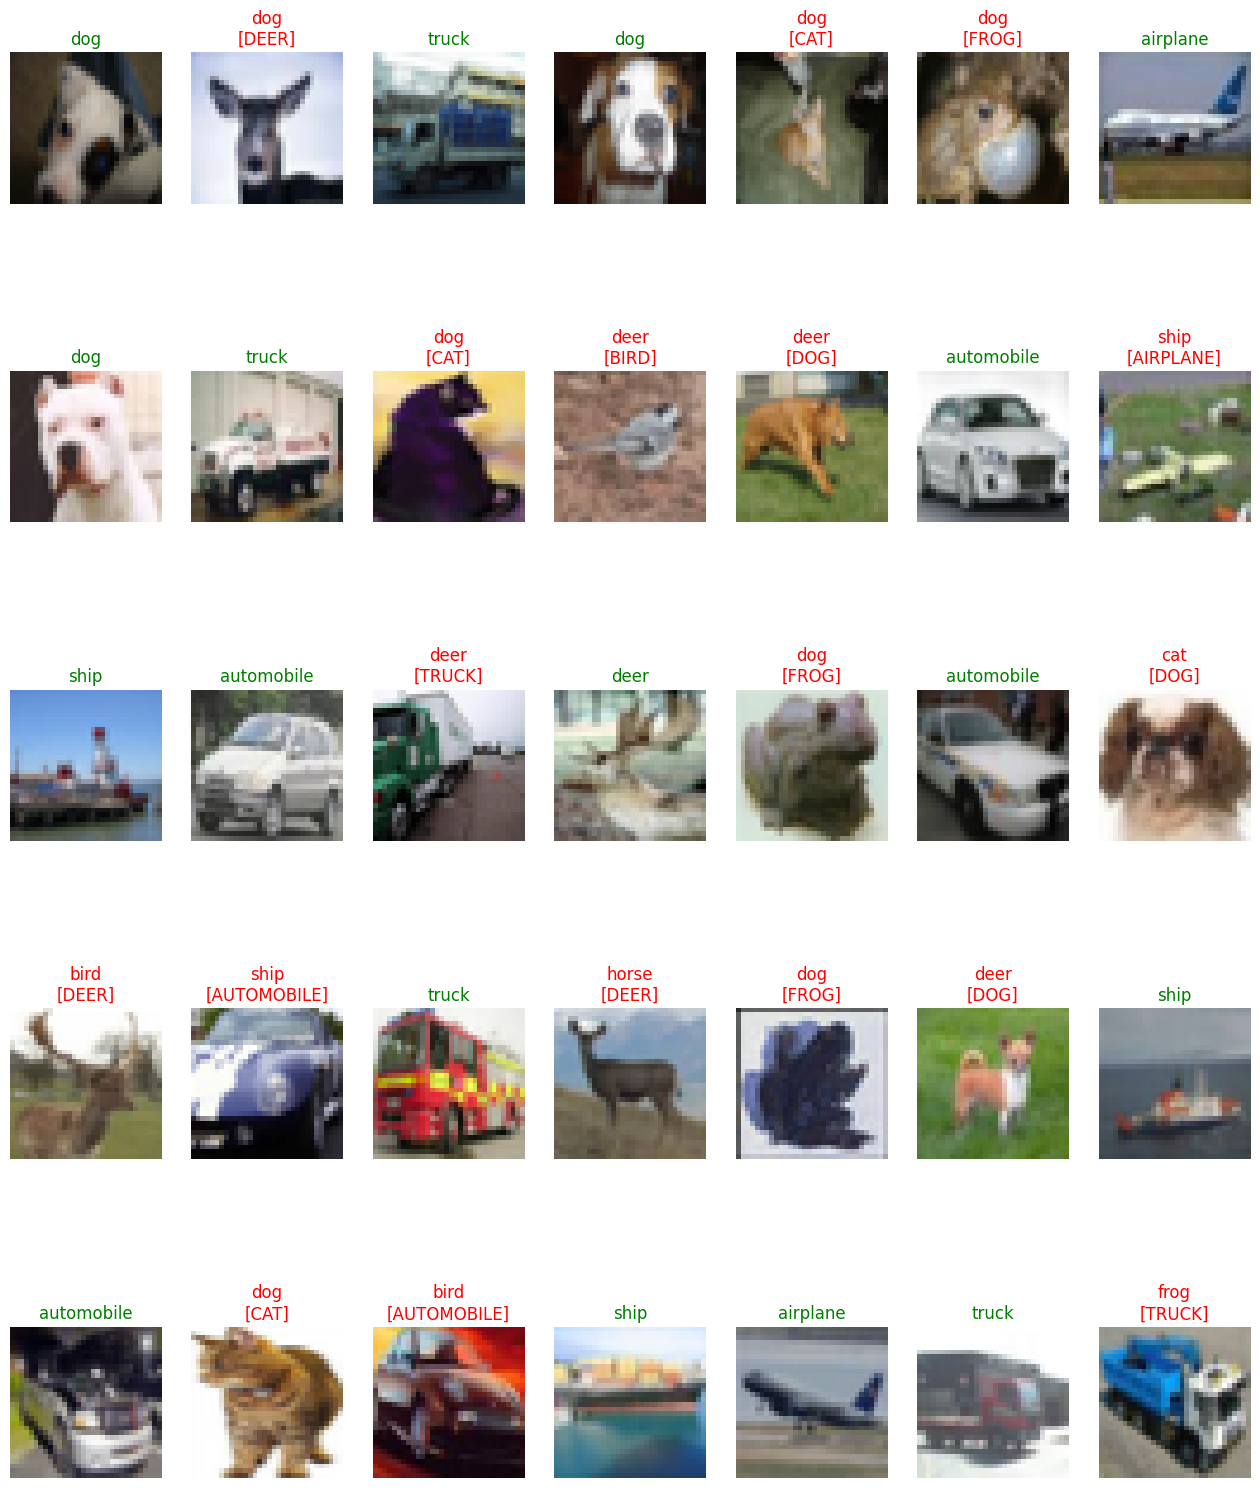

In [17]:
n_show, n_cols = 35, 7

n_rows = np.ceil(n_show/n_cols).astype(int)

plt.figure(figsize=(16,4*n_rows,))
for n,i in enumerate( rng.permutation(len(image_test))[:n_show] ):
    img = image_test[i]
    
    er = target_test[i]==o_test[i]
    t_mark = class_names[target_test[i]] 
    t_pred = class_names[o_test[i]] 
    t,c = (t_mark,'g') if er else (f'{t_pred}\n[{t_mark.upper()}]','r')
   
    plt.subplot(n_rows,n_cols,n+1)
    plt.axis(False)
    plt.title(t,color=c)
    plt.imshow(img,cmap='gray_r')
